In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from dadmm_experiment import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_nodes'] = 6
problem_spec['vector_size'] = 100
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()


problem_data['rho'] = 1.
problem_data['itr_num'] = 1000

{'n_nodes': 6, 'vector_size': 100}


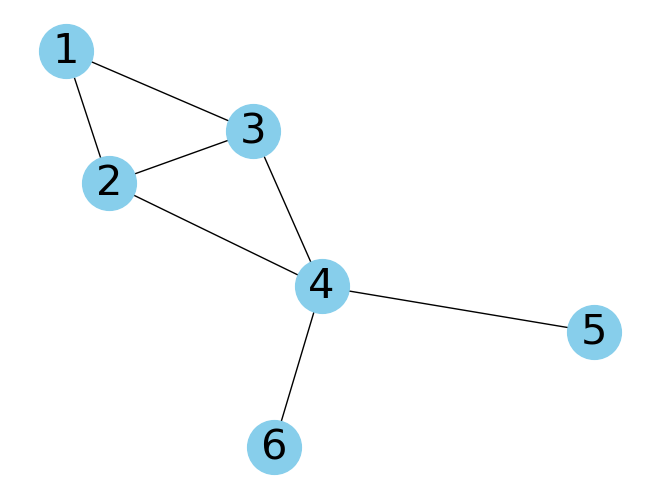

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=22245535.286031224, np.linalg.norm(x_opt_star)=2897.37763356345


In [5]:
b = problem_data['b']
P = problem_data['P']
 
vector_size = problem_spec['vector_size']
n_nodes = problem_spec['n_nodes']
prox_operators = []
fi_operators = []

for jj in range(n_nodes):
    bj = b[jj*vector_size : (jj+1)*vector_size]
    Pj = P[jj]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, Pj=Pj:  prox_fj_geom_mean_sc(z, rho, bj, Pj)]
        fi_operators += [lambda x_kj, bj=bj, Pj=Pj: 0.5 * (x_kj - bj).T @ Pj @ (x_kj - bj)]
    else:
        prox_operators += [lambda z, rho, bj=bj:  prox_fj_geom_mean(z, rho, bj)]
        fi_operators += [lambda x_kj, bj=bj: np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, Pj)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, Pj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5, print(jj, np.linalg.norm(x1 - x2) / np.linalg.norm(x1))

In [6]:
def dadmm_optimization_func(param):
    R = param
    problem_data['itr_num'] = 400
    admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, network_data, x_opt_star, f_star, prox_operators=prox_operators,
                              fi_operators=fi_operators, params={"R":R}, printing=False)[-1]
    return admm_f_reldiff

dadmm_R = co.grid_search(dadmm_optimization_func, [0.001, 0.01, 0.05, 0.02, 0.1, 0.5, 1, 5, 10, 100, 1000])

new param=0.001, new new_val=0.2712101028725152
new param=0.01, new new_val=0.004289012502205616
new param=0.05, new new_val=0.0005114744406651883
best_param = 0.05


In [7]:
R = dadmm_R
problem_data['itr_num'] = 1000
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.618544935391339, err_opt_reldiff[-1]=0.9454255082193875
ii=200, f_reldiff[-1]=1.5203999760465815e-06, err_opt_reldiff[-1]=0.00010996731340403795
ii=400, f_reldiff[-1]=5.993323031924704e-09, err_opt_reldiff[-1]=1.2112943298913214e-06
ii=600, f_reldiff[-1]=1.3703781535666637e-11, err_opt_reldiff[-1]=1.209802858742656e-06
ii=800, f_reldiff[-1]=4.2136884226273826e-12, err_opt_reldiff[-1]=1.2098054172014593e-06
ii=999, f_reldiff[-1]=4.2237361654680805e-12, err_opt_reldiff[-1]=1.2098054146068834e-06


In [8]:
def p_optimization_func(param):
    problem_data['rho'] = param
    problem_data['itr_num'] = 350
    pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star, printing=False)[-1]
    return pg_f_reldiff

pg_rho = co.grid_search(p_optimization_func, [0.001, 0.01, 0.05, 0.02, 0.1, 0.5, 1, 5, 10, 100, 1000])

new param=0.001, new new_val=0.07824138990914467
new param=0.01, new new_val=0.001408323931845459
best_param = 0.01


In [9]:
# apply P-EXTRA 
problem_data['rho'] = pg_rho
problem_data['itr_num'] = 1000
pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.6430456067996331, err_opt_reldiff[-1]=0.80728797185513
ii=200, f_reldiff[-1]=2.7584241668774134e-06, err_opt_reldiff[-1]=0.0014135100951953908
ii=400, f_reldiff[-1]=8.23874995264478e-07, err_opt_reldiff[-1]=7.534001795996381e-06
ii=600, f_reldiff[-1]=7.611525580871951e-09, err_opt_reldiff[-1]=9.285467180086516e-07
ii=800, f_reldiff[-1]=1.4729823542082583e-11, err_opt_reldiff[-1]=9.33092905857882e-07
ii=999, f_reldiff[-1]=4.834973854943875e-12, err_opt_reldiff[-1]=9.331460523199989e-07


In [19]:
def grid_search_dadmmc(optimization_func, R_vals, C_vals, L_vals, h_vals, start=50, end=350):
    best_value = np.inf
    for R in R_vals:
        for C in C_vals:
            for L in L_vals:
                for h in h_vals:
                    params={"R":R, "Inductance":L, "Capacitance":C, "h":h}
                    reldiff = optimization_func(params)
                    new_val = sum(reldiff[start:end]) / (end - start)
                    if new_val < best_value:
                        print(f"new {params=}, new {new_val=}")
                        best_value = new_val
                        best_param = params
    print(f"{best_param = }")
    return best_param

In [22]:
def dadmmc_optimization_func(params):
    problem_data['itr_num'] = 100
    dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data,  network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                    fi_operators=fi_operators,
                                    params=params, printing=False)[-1]
    return dadmm_c_f_reldiff

params = grid_search_dadmmc(dadmmc_optimization_func, 
                        R_vals=[0.01, 0.1, 1, 5], 
                        C_vals=[5, 10, 50, 100], 
                        L_vals=[1, 2, 5, 10],
                        h_vals=[1, 5, 10, 40], 
                        start=50, end=100)

new params={'R': 0.01, 'Inductance': 1, 'Capacitance': 5, 'h': 1}, new new_val=1.1114270996486877e+298


/var/folders/fp/rkwhsn_57zn3tz7fw_ct6s8m0000gn/T/ipykernel_22526/874469254.py:14: RuntimeWarning: overflow encountered in matmul
  fi_operators += [lambda x_kj, bj=bj, Pj=Pj: 0.5 * (x_kj - bj).T @ Pj @ (x_kj - bj)]
/var/folders/fp/rkwhsn_57zn3tz7fw_ct6s8m0000gn/T/ipykernel_22526/874469254.py:14: RuntimeWarning: invalid value encountered in matmul
  fi_operators += [lambda x_kj, bj=bj, Pj=Pj: 0.5 * (x_kj - bj).T @ Pj @ (x_kj - bj)]


new params={'R': 0.01, 'Inductance': 2, 'Capacitance': 5, 'h': 1}, new new_val=4.14849953409986e+297
new params={'R': 0.01, 'Inductance': 5, 'Capacitance': 5, 'h': 1}, new new_val=2.2915512306281814e+297
new params={'R': 0.01, 'Inductance': 10, 'Capacitance': 5, 'h': 1}, new new_val=1.8795200870831697e+297
new params={'R': 0.01, 'Inductance': 1, 'Capacitance': 10, 'h': 1}, new new_val=7.885283384111177e+235
new params={'R': 0.01, 'Inductance': 2, 'Capacitance': 10, 'h': 1}, new new_val=2.934578311296225e+235
new params={'R': 0.01, 'Inductance': 5, 'Capacitance': 10, 'h': 1}, new new_val=1.618334178378837e+235
new params={'R': 0.01, 'Inductance': 10, 'Capacitance': 10, 'h': 1}, new new_val=1.3266486420103718e+235
new params={'R': 0.01, 'Inductance': 1, 'Capacitance': 50, 'h': 1}, new new_val=1.0897284796257345e+74
new params={'R': 0.01, 'Inductance': 2, 'Capacitance': 50, 'h': 1}, new new_val=3.944891640527931e+73
new params={'R': 0.01, 'Inductance': 5, 'Capacitance': 50, 'h': 1}, new n

/Users/parshakova.tanya/Documents/projects/Circuits/optimization_via_circuits/ciropt/discretized_methods.py:49: RuntimeWarning: overflow encountered in scalar add
  f_val += fi_operators[jj](x_k[jj])


best_param = {'R': 0.1, 'Inductance': 1, 'Capacitance': 100, 'h': 5}


In [23]:
problem_data['itr_num'] = 1000
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.7993937411477964, err_opt_reldiff[-1]=0.9489001910121808
ii=200, f_reldiff[-1]=0.002517139924435133, err_opt_reldiff[-1]=0.0022339502002851875
ii=400, f_reldiff[-1]=1.923860763337261e-05, err_opt_reldiff[-1]=1.7733764569008603e-05
ii=600, f_reldiff[-1]=1.5708072555379889e-07, err_opt_reldiff[-1]=1.2197034705452114e-06
ii=800, f_reldiff[-1]=1.3054943517857146e-09, err_opt_reldiff[-1]=1.2098182600183455e-06
ii=999, f_reldiff[-1]=1.5328334090626827e-11, err_opt_reldiff[-1]=1.209805537540546e-06


In [ ]:
params = grid_search_dadmmc(dadmmc_optimization_func, 
                        R_vals=[0.01, 0.05, 0.1, 1, 5], 
                        C_vals=[5, 10, 50, 100], 
                        L_vals=[1, 2, 5, 10],
                        h_vals=[1, 5, 10, 40], 
                        start=50, end=100)

In [ ]:
problem_data['itr_num'] = 1000
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

In [14]:
params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.51541700023903}
# params={"R":2, "Inductance":1, "Capacitance":1, "h":0.66}
# params={"R":0.05, "Inductance":2, "Capacitance":1600, "h":40}
# params={"R":0.05, "Inductance":2, "Capacitance":1600, "h":40}


# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.842939271898937}
# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.13906193644284}
# params={"R":2, "Inductance":3, "Capacitance":0.5, "h":0.71692315906863}
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.321989931}
# params={"R":2, "Inductance":1, "Capacitance":1, "h":0.665836807162538}
# params={"R":1.5, "Inductance":4.5, "Capacitance":6, "h":3.50141019655701}
# params={"R":1, "Inductance":8, "Capacitance":8, "h":5.5409883749567}
# params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.515416990114254}
# params={"R":0.5, "Inductance":4, "Capacitance":16, "h":2.764408907848405}

problem_data['itr_num'] = 1000
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9789780042786801, err_opt_reldiff[-1]=0.9820554736513584
ii=200, f_reldiff[-1]=0.07482811226283169, err_opt_reldiff[-1]=0.0520758862782796
ii=400, f_reldiff[-1]=0.011747450583710807, err_opt_reldiff[-1]=0.008924871339461089
ii=600, f_reldiff[-1]=0.0020519570663277238, err_opt_reldiff[-1]=0.0016276818024434704
ii=800, f_reldiff[-1]=0.00037119862840355423, err_opt_reldiff[-1]=0.0003026530135401623
ii=999, f_reldiff[-1]=6.8917386437275e-05, err_opt_reldiff[-1]=5.722035449054288e-05


In [15]:
fname = "n6_circuit_dadmm_c"

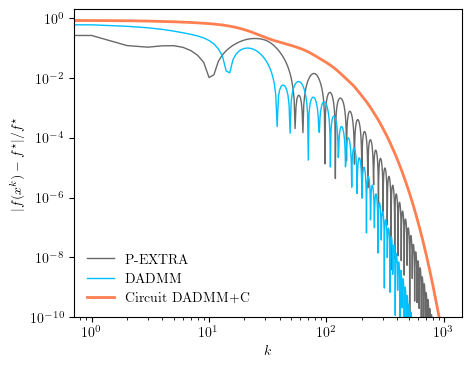

In [24]:
T = 1000
co.plot_methods([pg_f_reldiff[:T] ,admm_f_reldiff[:T], dadmm_c_f_reldiff[:T]],
                ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-10, 2e-0, fname)

In [13]:
np.where(np.array(dadmm_c_f_reldiff) < 1e-10)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
np.where(np.array(admm_f_reldiff) < 1e-10)[0][0]

In [ ]:
np.where(np.array(pg_f_reldiff) < 1e-10)[0][0]